#### Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import random
import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
 
## for explainer
from lime import lime_tabular
    
## plot style and warnings    
plt.style.use('ggplot')
from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')

### Abertura da Base de Dados

In [2]:
df = pd.read_csv('atpchina.csv', sep=',')

# **Data Preparation**

Neste notebook, vamos começar o terceiro passo do método CRIPS-DM: **Data Preparation.**

De seguida, iremos realizar :

- Limpeza de Dados;

- Redução de dados;

- Criação de Data Sampling;

- Data Transformation;

## **Limpeza de Dados**

Neste subcapítulo, o objetivo será limpar os dados, retirar os omissos na variável principal **Score**, substituir omissos por dados reais em variáveis de interesse e eliminar alguns duplicados.

### Duplicados

Em baixo, vamos eliminar os duplicados existentes na base de dados. Como foi possível ver no último notebook, existem 8 observações que são duplicadas.

Portanto, com base no número de observação delas, vão ser eliminadas.

In [3]:
df = df.drop_duplicates()
obs_existentes=df.shape[0] #Vamos guardar o número de observações atuais

### Missing Values de ***Score***

Aqui, iremos tratar dos valores omissos existentes na base de dados.

Como já foi dito, os valores omissos que estão na variável 'Score' serão eliminados, uma vez que, esta coluna será a coluna base para a variável target, então não faz sentido, fazermos imputação desses valores.

Também serão apagados os valores onde estão "(W/O)", estes valores significam que o jogo nem chegou a acontecer. 

Ou seja, quando um jogo não acontece por um jogador desistir, em vez de se dar um resultado específico, costuma-se dizer que aconteceu um Walkover.

In [4]:
df = df.dropna(subset=['Score'])
print(obs_existentes-df.shape[0])

652


In [5]:
df = df[df['Score'] != '(W/O)']

Neste momento, vai ser confirmado em baixo, já não devem existir omissos nas colunas 'WL' e 'GameRank'.

In [6]:
df.isna().sum()

PlayerName       0
Born          5209
Height        5239
Hand          2827
LinkPlayer       0
Tournament       0
Date             0
Ground           0
Prize          483
GameRound        0
GameRank         0
Oponent          0
WL               0
Score            0
Location         0
dtype: int64

### Missing Values de ***Prize***

Na variável Prize existem 483 NA's, a verdade é que para corrigirmos esta variável temos que verificar quais os torneios correspondentes aonde o Prize está NA. 

E esse é o primeiro passo a realizar.

In [7]:
df.loc[df['Prize'].isna(), 'Tournament'].unique()

array(['Beijing Olympics', 'AOG1 CHN vs KOR Round 1',
       'CHN vs. JPN DC Qualifier 1st Round', 'CHN vs. KAZ AOG I 2nd RD',
       'TPE vs. KAZ AOG I 1st RD', 'CHN vs. IND AOG1 2nd Round',
       'TPE vs. IRN AOG2 Play-Off', 'AOG1 TPE vs. CHN 1st Round',
       'CHN v. JPN AOG1 1st Rd', 'CHN vs. UZB AOGI 2nd Rd.',
       'CHN vs. UZB AOG I 1st RD', 'CHN vs. AUS AOG 1 2nd RD',
       'TPE vs. AUS AOGI 1st Rd.', 'TPE vs. KOR AOGI 1st Rd. Play-Off',
       'TPE vs. PHI AOGII 2nd Rd.', 'TPE vs. LIB AOGII 1st RD',
       'CHN vs. TPE AOGI 1st RD', 'TPE vs. IND AOG I 2nd RD',
       'TPE vs. AUS AOGI 1st. RD', 'TPE v. CHN AOGI 1st Rd PO',
       'TPE v. HKG AOGII 3rd RD', 'CHN v. TPE AOGII 2nd RD',
       'TPE v. KAZ AOGII', 'CHN vs. LIB AOGII 1st. RD',
       'CHN vs TPE AOGI Play-off', 'TPE vs. CHN AOG1 Play-off 1st Rd',
       'TPE vs. PHI AOG I Play-Offs', 'AOG1 CHN vs. NZL 1st Round',
       'CHN vs. NZL AOGI 1st Rd.', 'CHN vs. THA AOG I 3rd RD Play-off',
       'G2 BEN vs HKG Round 

Depois de rever que tipos de torneios acima eram, chegamos à conclusão de que tirando os jogos Olímpicos, todos os torneios restantes são de origem amigável.

Os torneios amigáveis em ténis são apenas torneios aonde os jogadores querem voltar a ter ritmo de jogo.

Como tal, chegou-se à conclusão que estes torneios deveriam ser apagados .

Em relação aos Jogos Olímpicos, estes são torneios que acontecem de 4 em 4 anos e que têm uma importância histórica, como tal, decidimos não eliminar estes jogos.

O problema é que vencer os Jogos Olímpicos não dá nenhum prémio monetário. Então, decidiu-se substituir por 0 na coluna Prize, no torneio dos jogos olimpicos.

In [8]:
tournaments_to_delete=['CHN vs. JPN DC Qualifier 1st Round',
                       'AOG1 CHN vs KOR Round 1',
                       'CHN vs. KAZ AOG I 2nd RD',
                       'TPE vs. KAZ AOG I 1st RD',
                       'CHN vs. IND AOG1 2nd Round',
                       'TPE vs. IRN AOG2 Play-Off',
                       'AOG1 TPE vs. CHN 1st Round',
                       'CHN v. JPN AOG1 1st Rd',
                       'CHN vs. UZB AOGI 2nd Rd.',
                       'CHN vs. UZB AOG I 1st RD',
                       'CHN vs. AUS AOG 1 2nd RD',
                       'TPE vs. AUS AOGI 1st Rd.',
                       'TPE vs. KOR AOGI 1st Rd. Play-Off',
                       'TPE vs. PHI AOGII 2nd Rd.',
                       'TPE vs. LIB AOGII 1st RD',
                       'CHN vs. TPE AOGI 1st RD',
                       'TPE vs. IND AOG I 2nd RD',
                       'TPE vs. AUS AOGI 1st. RD',
                       'TPE v. CHN AOGI 1st Rd PO',
                       'TPE v. HKG AOGII 3rd RD',
                       'CHN v. TPE AOGII 2nd RD',
                       'TPE v. KAZ AOGII',
                       'CHN vs. LIB AOGII 1st. RD',
                       'CHN vs TPE AOGI Play-off',
                       'TPE vs. CHN AOG1 Play-off 1st Rd',
                       'TPE vs. PHI AOG I Play-Offs',
                       'AOG1 CHN vs. NZL 1st Round',
                       'CHN vs. NZL AOGI 1st Rd.',
                       'CHN vs. THA AOG I 3rd RD Play-off',
                       'G2 BEN vs HKG Round 1',
                       'TPE vs. INA AOGI 2nd Rd. Play-Off',
                       'TPE v. THA AOG1 1st Rd',
                       'TPE v. PAK AOGI 1st RD',
                       'TPE v. KOR AOGI 2nd Rd.',
                       'TPE v. UZB AOG1 1st RD',
                       'CHN v. PAK AOGI 2nd Rd. PO',
                       'TPE vs. MAS AOG2 1st RD',
                       'CHN v. KUW AOGII 2nd Rd.',
                       'THA V CHN AOG1',
                       'KOR V CHN AOG1',
                       'CHN v KUW AOZ2 Rd 1',
                       'CHN v. INA AOGI 2nd RD PO',
                       'CHN v. PHI AOGII',
                       'NZL V CHN AOZ1',
                       'IND v CHN AOGI Rd 1',
                       'UZB V CHN AZO1',
                       'UZB V CHN AOG1',
                       'JPN V CHN AZ1',
                       'INO V CHN AOZ',
                       'NZL V CHN EZF']

df=df[~df['Tournament'].isin(tournaments_to_delete)]

In [9]:
df.loc[df['Tournament']=='Beijing Olympics', 'Prize']=0

### Criação do Rank do Jogador

In [10]:
player_info = df[['Oponent', 'Date', 'GameRank']]
player_info.shape
for index, row in df.iterrows():
    player_name = row['PlayerName']
    date = row['Date']
    matching_rows = player_info[(player_info['Oponent'] == player_name) & (player_info['Date'] == date)]
    if not matching_rows.empty:
        rank = matching_rows.iloc[0]['GameRank']
        df.loc[index, 'PlayerRank'] = rank

### Limpeza dos Jogos

Em baixo, vamos proceder à limpeza dos jogos, ou seja, na nossa base de dados existem jogos que são espelhados e que não são espelhados.

O objetivo será então:

**Guardar os jogos que estão espelhados numa variável e os que não estão noutra variável;**

Os jogos que estiverem espelhados (metade deles serão eliminados), só vamos guardar os jogos aonde o PlayerName ganha o jogo (ou seja, aonde na coluna WL aparece 'W').

Os jogos que não estiverem espelhados, iremos contá-los e depois tomar uma decisão sobre os mesmos.

In [11]:
df_mirror = df.copy()
df_mirror['Oponent'], df_mirror['PlayerName'] = df_mirror['PlayerName'], df_mirror['Oponent']

# concatenate the original DataFrame and the mirrored DataFrame
df_concat = pd.concat([df, df_mirror], axis=0, ignore_index=True)

# group the concatenated DataFrame by the four columns you want to compare and count the number of rows in each group
counted = df_concat.groupby(['Date', 'GameRound', 'Oponent', 'PlayerName']).size().reset_index(name='count')

# filter the resulting DataFrame to find the matching rows
matching_rows = counted[counted['count'] > 1]

# print the number of matching rows
print(len(matching_rows))

# filter the original DataFrame to find the rows that are not in matching_rows
unmatched_rows = df[~df.set_index(['Date', 'GameRound', 'Oponent', 'PlayerName']).index.isin(matching_rows.set_index(['Date', 'GameRound', 'Oponent', 'PlayerName']).index)]

# create a list of the unmatched rows
unmatched_list = unmatched_rows.to_dict('records')

# print the unmatched rows as a list of dictionaries
my_list = list(unmatched_list)
print(my_list[100])

23816
{'PlayerName': 'Jo-Wilfried Tsonga', 'Born': 'Le Mans, France', 'Height': 188.0, 'Hand': 'Right-Handed, Two-Handed Backhand', 'LinkPlayer': 'https://www.atptour.com/en/players/jo-wilfried-tsonga/t786/player-activity?year=all&matchType=Singles', 'Tournament': 'ATP Masters 1000 Shanghai', 'Date': '2012.10.08 - 2012.10.14', 'Ground': 'Hard', 'Prize': '$3,531,600', 'GameRound': 'Round of 16', 'GameRank': '36', 'Oponent': 'Marcos Baghdatis', 'WL': 'W', 'Score': '62 76', 'Location': 'China', 'PlayerRank': '6'}


In [12]:
print(df.shape[0] - len(matching_rows))

1363


Portanto, o que podemos concluir é que dentro do nosso df, existem 1363 observações que não são espelhadas, mas ainda não verificámos um cenário.

O nosso objetivo é guardar todos os jogos aonde o PlayerName vence o jogo, e o que até agora nós sabemos é que existem 1363 observações que não são espelhadas.

Portanto, o próximo passo será percorrer o my_list e contar o número de observações em que o PlayerName vence o jogo.

In [13]:
df_nao_espelhados=pd.DataFrame(my_list)
print(len(df_nao_espelhados))

1363


In [14]:
len(df_nao_espelhados[df_nao_espelhados['WL'] == 'W'])

1013

Portanto, das 1363 observações que não estão espelhadas, 1013 já tem o PlayerName como vencedor do encontro (teríamos que espelhar 353 jogos).

Podemos dizer então que a nossa base de dados final com os jogos limpos, terá 12921 jogos (sem espelhar os 350 jogos).

Como tal, devido a acharmos que estes 350 jogos não irão prejudicar os modelo, decidimos não espelhar os jogos.

Então em baixo, vamos apagar os jogos aonde WL="L".

In [15]:
df_nao_espelhados = df_nao_espelhados[df_nao_espelhados['WL'] == 'W']
len(df_nao_espelhados)

1013

In [16]:
matched_df = pd.merge(df, matching_rows, on=['Date', 'GameRound', 'Oponent', 'PlayerName'], how='inner')
matched_df.shape

(23816, 17)

Em baixo, vamos remover a coluna count , uma vez que neste dataframe matched_df não faz sentido ter essa coluna.

In [17]:
matched_df = matched_df.drop('count', axis=1)
matched_df.head(6)

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,GameRank,Oponent,WL,Score,Location,PlayerRank
0,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2019.10.07 - 2019.10.13,Hard,"$7,473,620",Quarter-Finals,7,Stefanos Tsitsipas,L,63 57 36,China,1
1,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2019.10.07 - 2019.10.13,Hard,"$7,473,620",Round of 32,36,Denis Shapovalov,W,63 63,China,1
2,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2019.10.07 - 2019.10.13,Hard,"$7,473,620",Round of 16,17,John Isner,W,75 63,China,1
3,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2018.10.08 - 2018.10.14,Hard,"$7,086,700",Finals,19,Borna Coric,W,63 64,China,3
4,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2018.10.08 - 2018.10.14,Hard,"$7,086,700",Quarter-Finals,8,Kevin Anderson,W,"76, 63",China,3
5,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2018.10.08 - 2018.10.14,Hard,"$7,086,700",Semi-Finals,5,Alexander Zverev,W,62 61,China,3


O próximo passo é então eliminar os jogos de matched_df onde WL="L" , devemos ficar com 11984 observações neste dataframe.

De seguida, vamos fazer um merge entre o matched_df e o df_nao_espelhados. 

Neste novo dataframe já teremos os jogos limpos, não espelhados, e com o PlayerName a obter a vitória.

In [18]:
matched_df = matched_df[matched_df['WL'] == 'W']
len(matched_df)

11908

In [19]:
new_df = pd.concat([df_nao_espelhados, matched_df], axis=0, ignore_index=True)
len(new_df)

12921

Em baixo, vamos verificar quantos NA's temos neste novo dataframe (só deveremos ter NA's nas colunas Hand, Height e Born) e vamos verificar se temos observações onde WL="L".

In [20]:
new_df.isna().sum()

PlayerName       0
Born          2210
Height        2216
Hand          1096
LinkPlayer       0
Tournament       0
Date             0
Ground           0
Prize            0
GameRound        0
GameRank         0
Oponent          0
WL               0
Score            0
Location         0
PlayerRank      38
dtype: int64

In [21]:
len(new_df[new_df['WL'] == 'L'])

0

Podemos então concluir, que a limpeza dos jogos está realizada.

Falta então agora, tratar das variáveis Born, Height e Hand. Tal como falta, criarmos e/ou agrupar novas colunas, para finalizarmos este passo do Data Preparation.

## **Data Transformation**

Nesta fase, iremos então tratar das variáveis já limpas:

- Agrupar variáveis que podem ser agrupadas;

- Criar novas variáveis.

### Criação do BornDate

Em baixo, vamos criar uma nova coluna no new_df com o BornDate (data de nascimento de cada jogador).

Como tal, vamos usar uma base de dados encontrada na internet para auxiliar-nos.

In [22]:
df_player_data_original=pd.read_csv('player_overviews_unindexed.csv',sep=",")

In [23]:
df_player_data=pd.DataFrame()
df_player_data["PlayerName"]=df_player_data_original['first_name'] + ' ' + df_player_data_original['last_name']
df_player_data['LinkPlayer'] = df_player_data_original['player_url']
df_player_data['birthdate']=df_player_data_original['birthdate']
df_player_data['birth_year'] =df_player_data_original['birth_year']

In [24]:
for i in range(len(df_player_data)):
    df_player_data.loc[i,'LinkPlayer'] = df_player_data.loc[i,'LinkPlayer'] [:14] + df_player_data.loc[i,'LinkPlayer'] [19:]

In [25]:
df_player_data['LinkPlayer'] = df_player_data['LinkPlayer'].apply(lambda x: x[:4] + 's' + x[4:])
get_overview_link = lambda link: link[:link.rfind('/')+1] + 'overview'
new_df['OverviewLink'] = new_df['LinkPlayer'].apply(get_overview_link)

In [26]:
for index, row in new_df.iterrows():
    link = row['OverviewLink']
    matching_row = df_player_data[df_player_data['LinkPlayer'] == link]
    if not matching_row.empty:
        birthdate = matching_row['birthdate'].iloc[0]
        new_df.loc[index, 'BornDate'] = birthdate

In [27]:
print("Quantidade de jogadores cuja variável 'BornDate' é um valor 'Null': " + str(new_df[new_df['BornDate'].isnull()]['PlayerName'].nunique()))

Quantidade de jogadores cuja variável 'BornDate' é um valor 'Null': 390


Ainda temos alguns Null na base de dados, então foi decidido preencher os valores à mão.

Então, criou-se um novo csv (df_missing_borndate) com as restantes datas de nascimento.

In [28]:
df_missing_borndate = pd.read_csv('df_missing_borndate.csv', sep=';')
len(df_missing_borndate)

1639

In [29]:
for index, row in new_df.iterrows():
    link = row['PlayerName']
    matching_row = df_missing_borndate[df_missing_borndate['PlayerName'] == link]
    if not matching_row.empty:
        birthdate = matching_row['BornDate'].iloc[0]
        new_df.loc[index, 'BornDate'] = birthdate

In [30]:
print("Quantidade de jogadores cuja variável 'BornDate' é um valor 'Null': " + str(new_df[new_df['BornDate'].isnull()]['PlayerName'].nunique()))

Quantidade de jogadores cuja variável 'BornDate' é um valor 'Null': 0


Já temos a coluna BornDate preenchida, o que nos vai possibilitar contar a diferença de idades entre o PlayerName e o Oponent.

Portanto, vamos agora calcular a idade dos jogadores durante o torneio, criando então novas colunas (como a do Start_Date e End_Date). 

Também vamos criar colunas para a idade do PlayerName e Oponent.

In [31]:
new_df.head(6)

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,GameRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate
0,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2015.10.05 - 2015.10.11,Hard,"$2,700,510",Semi-Finals,7,David Ferrer,W,62 63,China,1,https://www.atptour.com/en/players/novak-djoko...,1987.05.22
1,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2014.10.06 - 2014.10.12,Hard,"$4,195,895",Quarter-Finals,5,David Ferrer,W,64 62,China,1,https://www.atptour.com/en/players/novak-djoko...,1987.05.22
2,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2014.09.29 - 2014.10.05,Hard,"$2,500,470",Finals,6,Tomas Berdych,W,60 62,China,1,https://www.atptour.com/en/players/novak-djoko...,1987.05.22
3,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Quarter-Finals,21,Tommy Haas,W,63 63,China,2,https://www.atptour.com/en/players/novak-djoko...,1987.05.22
4,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Semi-Finals,7,Tomas Berdych,W,63 64,China,2,https://www.atptour.com/en/players/novak-djoko...,1987.05.22
5,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2012.10.01 - 2012.10.07,Hard,"$2,205,000",Round of 16,50,Carlos Berlocq,W,61 63,China,2,https://www.atptour.com/en/players/novak-djoko...,1987.05.22


Existem agora mais 1 passo a realizar:

- Criar a coluna BornDate para os Opponents.

In [32]:
#Criação da coluna BornDate_Oponent no new_df

for index, row in new_df.iterrows():
    link = row['Oponent']
    matching_row = df_player_data[df_player_data['PlayerName'] == link]
    if not matching_row.empty:
        birthdate = matching_row['birthdate'].iloc[0]
        new_df.loc[index, 'OponentBornDate'] = birthdate
        
print("Quantidade de Oponent cuja variável 'OponentBornDate' é um valor 'Null': " + str(new_df[new_df['OponentBornDate'].isnull()]['Oponent'].nunique()))

Quantidade de Oponent cuja variável 'OponentBornDate' é um valor 'Null': 764


In [33]:
for index, row in new_df.iterrows():
    link = row['Oponent']
    matching_row = df_missing_borndate[df_missing_borndate['PlayerName'] == link]
    if not matching_row.empty:
        birthdate = matching_row['BornDate'].iloc[0]
        new_df.loc[index, 'OponentBornDate'] = birthdate
        
print("Quantidade de Oponent cuja variável 'OponentBornDate' é um valor 'Null': " + str(new_df[new_df['OponentBornDate'].isnull()]['Oponent'].nunique()))

Quantidade de Oponent cuja variável 'OponentBornDate' é um valor 'Null': 267


In [34]:
df_missing_borndate_op = pd.read_csv('df_missing_borndate_op.csv', sep=';')

for index, row in new_df.iterrows():
    link = row['Oponent']
    matching_row = df_missing_borndate_op[df_missing_borndate_op['Oponent'] == link]
    if not matching_row.empty:
        birthdate = matching_row['OponentBornDate'].iloc[0]
        new_df.loc[index, 'OponentBornDate'] = birthdate
        
print("Quantidade de Oponent cuja variável 'OponentBornDate' é um valor 'Null': " + str(new_df[new_df['OponentBornDate'].isnull()]['Oponent'].nunique()))

Quantidade de Oponent cuja variável 'OponentBornDate' é um valor 'Null': 0


In [35]:
new_df.isna().sum()

PlayerName            0
Born               2210
Height             2216
Hand               1096
LinkPlayer            0
Tournament            0
Date                  0
Ground                0
Prize                 0
GameRound             0
GameRank              0
Oponent               0
WL                    0
Score                 0
Location              0
PlayerRank           38
OverviewLink          0
BornDate              0
OponentBornDate       0
dtype: int64

### Tratamento dos Rankings

Uma das variáveis que vamos usar é a diferença entre o ranking do PLayerName para o ranking do Oponent.

Atualmente, só temos os rankings do Oponent, como tal, temos que criar um código para obter os rankings no PlayerName, e é isso que vamos fazer de seguida.

In [36]:
new_df.rename(columns = {'GameRank':'OponentRank'}, inplace = True)

Em baixo, vamos tratar das duas colunas dos Rankings que temos para tratar: PlayerRank (coluna que representa o ranking do PlayerName) e OponentRank (coluna que representa o Ranking dos Oponents).

O que vamos fazer é substituir todos os Na's e todas as observações que estão "-", substituindo pela mediana do jogador.

In [37]:
new_df['PlayerRank'] = new_df['PlayerRank'].replace('-', 0)
new_df['OponentRank'] = new_df['OponentRank'].replace('-', 0)
new_df['PlayerRank'] = new_df['PlayerRank'].fillna(0)

In [38]:
new_df[new_df['OponentRank'] == 9999]

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,OponentRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate


In [39]:
new_df.isna().sum()

PlayerName            0
Born               2210
Height             2216
Hand               1096
LinkPlayer            0
Tournament            0
Date                  0
Ground                0
Prize                 0
GameRound             0
OponentRank           0
Oponent               0
WL                    0
Score                 0
Location              0
PlayerRank            0
OverviewLink          0
BornDate              0
OponentBornDate       0
dtype: int64

In [40]:
def get_mode_rank(df, player_name):
    df['PlayerRank'] = pd.to_numeric(df['PlayerRank'], errors='coerce')
    df['OponentRank'] = pd.to_numeric(df['OponentRank'], errors='coerce')
    player_rank = df[df['PlayerName'] == player_name]['PlayerRank']
    opponent_rank = df[df['Oponent'] == player_name]['OponentRank']
    ranks = pd.concat([player_rank, opponent_rank], axis=0)
    non_zero_ranks = ranks[ranks != 0]
    if len(non_zero_ranks) == 0:
        return np.nan
    else:
        return non_zero_ranks.mode()[0]
print(get_mode_rank(new_df,'Andy Murray'))

4


In [41]:
def fill_rank(row):
    if row['PlayerRank'] == 0:
        row['PlayerRank'] = get_mode_rank(new_df, row['PlayerName'])
    if row['OponentRank'] == 0:
        row['OponentRank'] = get_mode_rank(new_df, row['Oponent'])
    return row

new_df = new_df.apply(fill_rank, axis=1)

In [42]:
new_df.isna().sum()

PlayerName            0
Born               2210
Height             2216
Hand               1096
LinkPlayer            0
Tournament            0
Date                  0
Ground                0
Prize                 0
GameRound             0
OponentRank         632
Oponent               0
WL                    0
Score                 0
Location              0
PlayerRank           96
OverviewLink          0
BornDate              0
OponentBornDate       0
dtype: int64

In [43]:
(new_df['PlayerRank'] == 0).sum()

0

In [44]:
(new_df['OponentRank'] == 0).sum()

0

In [45]:
new_df.isna().sum()

PlayerName            0
Born               2210
Height             2216
Hand               1096
LinkPlayer            0
Tournament            0
Date                  0
Ground                0
Prize                 0
GameRound             0
OponentRank         632
Oponent               0
WL                    0
Score                 0
Location              0
PlayerRank           96
OverviewLink          0
BornDate              0
OponentBornDate       0
dtype: int64

In [46]:
new_df[new_df['PlayerRank'].isna()]

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,OponentRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate
224,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.14 - 2019.01.20,Clay,"$15,000",Round of 32,NaN,Liran Chen,W,62 61,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,1997.08.25
411,William Ma,Melbourne,183.0,"Right-Handed, One-Handed Backhand",https://www.atptour.com/en/players/william-ma/...,China F8,2018.06.04 - 2018.06.10,Hard,"$25,000",Round of 32,NaN,Ruitong Fang,W,64 64,China,NaN,https://www.atptour.com/en/players/william-ma/...,1995.09.09,1997.01.15
572,Jia-Hong Shen,NaN,NaN,NaN,https://www.atptour.com/en/players/jia-hong-sh...,Chinese Taipei F2,2017.06.19 - 2017.06.25,Hard,"$25,000",Round of 32,NaN,Chang wu Lu,W,57 64 64,China,NaN,https://www.atptour.com/en/players/jia-hong-sh...,1995.02.26,1996.05.17
574,Yu chang Wang,NaN,NaN,NaN,https://www.atptour.com/en/players/yu-chang-wa...,Chinese Taipei F2,2017.06.19 - 2017.06.25,Hard,"$25,000",Round of 32,NaN,Liang-Yu Lin,W,63 61,China,NaN,https://www.atptour.com/en/players/yu-chang-wa...,1997.05.23,1997.11.25
583,Richard Yang,NaN,NaN,NaN,https://www.atptour.com/en/players/richard-yan...,Chinese Taipei F1,2017.06.12 - 2017.06.18,Hard,"$25,000",Round of 32,NaN,Liang-Yu Lin,W,63 64,China,NaN,https://www.atptour.com/en/players/richard-yan...,1997.06.16,1997.11.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12845,Grigoriy Lomakin,Temirtau,198.0,"Right-Handed, Unknown Backhand",https://www.atptour.com/en/players/grigoriy-lo...,M15 Anning,2019.01.14 - 2019.01.20,Clay,"$15,000",Round of 32,1506.0,Ren Nakamura,W,63 26 64,China,NaN,https://www.atptour.com/en/players/grigoriy-lo...,1998.03.18,1995.01.31
12869,Ivan Liutarevich,Minsk,196.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/ivan-liutar...,M25 Yinchuan,2019.06.24 - 2019.06.30,Hard,"$25,000",Round of 32,1922.0,Rui-Xuan Wang,W,62 64,China,NaN,https://www.atptour.com/en/players/ivan-liutar...,1996.02.20,1996.03.27
12886,Jesse Delaney,Sydney,173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/jesse-delan...,M25 Taipei,2019.07.15 - 2019.07.21,Hard,"$25,000",Round of 32,542.0,Wishaya Trongcharoenchaikul,W,36 61 62,China,NaN,https://www.atptour.com/en/players/jesse-delan...,1998.11.14,1995.04.08
12887,Jesse Delaney,Sydney,173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/jesse-delan...,M25 Taipei,2019.07.15 - 2019.07.21,Hard,"$25,000",Round of 16,1925.0,Wei-De Lin,W,75 61,China,NaN,https://www.atptour.com/en/players/jesse-delan...,1998.11.14,1996.02.05


In [47]:
new_df[new_df['PlayerName']== "Naoki Tajima"]

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,OponentRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate
224,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.14 - 2019.01.20,Clay,"$15,000",Round of 32,NaN,Liran Chen,W,62 61,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,1997.08.25
5944,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.14 - 2019.01.20,Clay,"$15,000",Round of 16,660.0,Michael Zhu,W,62 63,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,1992.08.12
5945,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.07 - 2019.01.13,Clay,"$15,000",Semi-Finals,1325.0,Shao-Fan Liu,W,26 61 63,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,1997.01.30
5946,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.07 - 2019.01.13,Clay,"$15,000",Round of 32,1007.0,Ye Cong Mo,W,36 64 63,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,2000.06.26
5947,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.07 - 2019.01.13,Clay,"$15,000",Quarter-Finals,542.0,N Vijay Sundar Prashanth,W,63 62,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,1986.10.27
5948,Naoki Tajima,"Kumamoto, Japan",173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/naoki-tajim...,M15 Anning,2019.01.07 - 2019.01.13,Clay,"$15,000",Round of 16,655.0,Issei Okamura,W,46 63 64,China,NaN,https://www.atptour.com/en/players/naoki-tajim...,2000.09.21,1992.05.26


In [48]:
new_df[new_df['OponentRank'].isna()]['Oponent'].unique()

array(['Jiacheng Zhu', 'Renlong Pang', 'Zheng Li', 'You-Xu Shen',
       'Yi fan Wu', 'Jackson Withrow', 'Chun-En Wu', 'Shenghan Li',
       'Pengyu Lu', 'Jiaqi Duan', 'Che-Ching Yeh', 'Jiancheng Zhu',
       'Yuquan Jin', 'Da-Wei Li', 'Yu Feng Chen', 'Yang Jiang',
       'Chang-Lin Tsai', 'Jia qi Huang', 'Yang Liu', 'Ze Shuo Yang',
       'Zhenxiong Dong', 'Ting-Hou He', 'Ching-Huang Tsai', 'Wenmao Li',
       'Xiaoyu He', 'Vimalraj Jayachandran', 'Xingyu Zou', 'Jing Zhao',
       'Qin Nong Yang', 'Linang Xiao', 'Jun tong Gao', 'Isaiah Mao',
       'Pengxuan Jiang', 'Keng-Cheng Lin', 'Liran Chen', 'Winter Meagher',
       'Honghan Wang', 'Kai-Jie Lin', 'Michael Lai', 'Lukas Storck',
       'Ang Ji', 'Meng-Hua Lee', 'Ying-Zheng Wang', 'Sida Zeng', 'Ao Li',
       'Jonathan Chang', 'Qiu Shi Dong', 'Prithvi Sekhar', 'Tin Chen',
       'Jordan Chiu', 'Sultan Narbekov', 'Fei Ti Liao', 'Chung Han Tsai',
       'Xian Wu', 'Ya Hui Nie', 'Zekai Li', 'Yu Han', 'Daniel Yoon',
       'Liang-Yu Li

In [49]:
new_df[new_df['PlayerRank'].isna()]['PlayerName'].unique()

array(['Naoki Tajima', 'William Ma', 'Jia-Hong Shen', 'Yu chang Wang',
       'Richard Yang', 'Tristan-Samuel Weissborn', 'Andre Begemann',
       'Giuseppe Menga', 'Dor Wertheimer', 'Fan fan Zeng', 'Ai-Min Zhang',
       'Zeeshan Ali', 'Yi Liu', 'Jimmy Connors', 'Ken Flach',
       'John Marinov', 'Yannick Noah', 'Ivan Lendl', 'Matt Anger',
       'John Frawley', 'Bingyu Yu', 'Eric Vanshelboim', 'Garrett Johns',
       'Lukas Krainer', 'Qun Gao', 'Sam Taylor', 'Sho Shimabukuro',
       'Jonathan Mridha', 'Seon Yong Han', 'Ruben Gonzales',
       'Igor Zelenay', 'Ognian Kolev', 'Jie-Ming Pai', 'Mate Pavic',
       "David O'Hare", 'Byung-Kook Kang', 'Jae Won Yun', 'Yohny Romero',
       'Manuel Jorquera', 'Johan Brunstrom', 'Robert Haybittel',
       'Rong Ma', 'Xiao Long Yin', 'Ion Moldovan', 'Jian Li',
       'Nian-Fei Zhang', 'Alexander Crnokrak', 'Andrea Bessire',
       'Grigoriy Lomakin', 'Ivan Liutarevich', 'Jesse Delaney'],
      dtype=object)

In [50]:
new_df['OponentRank'] = new_df['OponentRank'].fillna(9999)

In [51]:
new_df.loc[new_df['PlayerName'] == 'Naoki Tajima', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Naoki Tajima', 'PlayerRank'].fillna(value=749)
new_df.loc[new_df['PlayerName'] == 'William Ma', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'William Ma', 'PlayerRank'].fillna(value=1705)
new_df.loc[new_df['PlayerName'] == 'Jia-Hong Shen', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jia-Hong Shen', 'PlayerRank'].fillna(value=1675)
new_df.loc[new_df['PlayerName'] == 'Yu chang Wang', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Yu chang Wang', 'PlayerRank'].fillna(value=1675)
new_df.loc[new_df['PlayerName'] == 'Richard Yang', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Richard Yang', 'PlayerRank'].fillna(value=1648)
new_df.loc[new_df['PlayerName'] == 'Tristan-Samuel Weissborn', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Tristan-Samuel Weissborn', 'PlayerRank'].fillna(value=1220)
new_df.loc[new_df['PlayerName'] == 'Andre Begemann', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Andre Begemann', 'PlayerRank'].fillna(value=749)
new_df.loc[new_df['PlayerName'] == 'Giuseppe Menga', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Giuseppe Menga', 'PlayerRank'].fillna(value=1226)
new_df.loc[new_df['PlayerName'] == 'Dor Wertheimer', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Dor Wertheimer', 'PlayerRank'].fillna(value=1418)
new_df.loc[new_df['PlayerName'] == 'Fan fan Zeng', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Fan fan Zeng', 'PlayerRank'].fillna(value=1340)
new_df.loc[new_df['PlayerName'] == 'Ai-Min Zhang', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ai-Min Zhang', 'PlayerRank'].fillna(value=1418)
new_df.loc[new_df['PlayerName'] == 'Zeeshan Ali', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Zeeshan Ali', 'PlayerRank'].fillna(value=142)
new_df.loc[new_df['PlayerName'] == 'Yi Liu', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Yi Liu', 'PlayerRank'].fillna(value=1391)
new_df.loc[new_df['PlayerName'] == 'Jimmy Connors', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jimmy Connors', 'PlayerRank'].fillna(value=3)
new_df.loc[new_df['PlayerName'] == 'Ken Flach', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ken Flach', 'PlayerRank'].fillna(value=678)
new_df.loc[new_df['PlayerName'] == 'John Marinov', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'John Marinov', 'PlayerRank'].fillna(value=1085)
new_df.loc[new_df['PlayerName'] == 'Yannick Noah', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Yannick Noah', 'PlayerRank'].fillna(value=49)
new_df.loc[new_df['PlayerName'] == 'Ivan Lendl', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ivan Lendl', 'PlayerRank'].fillna(value=8)
new_df.loc[new_df['PlayerName'] == 'Matt Anger', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Matt Anger', 'PlayerRank'].fillna(value=187)
new_df.loc[new_df['PlayerName'] == 'John Frawley', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'John Frawley', 'PlayerRank'].fillna(value=444)
new_df.loc[new_df['PlayerName'] == 'Bingyu Yu', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Bingyu Yu', 'PlayerRank'].fillna(value=1793)
new_df.loc[new_df['PlayerName'] == 'Eric Vanshelboim', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Eric Vanshelboim', 'PlayerRank'].fillna(value=1491)
new_df.loc[new_df['PlayerName'] == 'Garrett Johns', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Garrett Johns', 'PlayerRank'].fillna(value=1396)
new_df.loc[new_df['PlayerName'] == 'Lukas Krainer', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Lukas Krainer', 'PlayerRank'].fillna(value=1398)
new_df.loc[new_df['PlayerName'] == 'Qun Gao', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Qun Gao', 'PlayerRank'].fillna(value=1704)
new_df.loc[new_df['PlayerName'] == 'Sam Taylor', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Sam Taylor', 'PlayerRank'].fillna(value=1577)
new_df.loc[new_df['PlayerName'] == 'Sho Shimabukuro', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Sho Shimabukuro', 'PlayerRank'].fillna(value=713)
new_df.loc[new_df['PlayerName'] == 'Jonathan Mridha', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jonathan Mridha', 'PlayerRank'].fillna(value=606)
new_df.loc[new_df['PlayerName'] == 'Seon Yong Han', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Seon Yong Han', 'PlayerRank'].fillna(value=1209)
new_df.loc[new_df['PlayerName'] == 'Ruben Gonzales', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ruben Gonzales', 'PlayerRank'].fillna(value=1583)
new_df.loc[new_df['PlayerName'] == 'Igor Zelenay', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Igor Zelenay', 'PlayerRank'].fillna(value=1179)
new_df.loc[new_df['PlayerName'] == 'Ognian Kolev', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ognian Kolev', 'PlayerRank'].fillna(value=1645)
new_df.loc[new_df['PlayerName'] == 'Jie-Ming Pai', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jie-Ming Pai', 'PlayerRank'].fillna(value=1614)
new_df.loc[new_df['PlayerName'] == 'Mate Pavic', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Mate Pavic', 'PlayerRank'].fillna(value=974)
new_df.loc[new_df['PlayerName'] == "David O'Hare", 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == "David O'Hare", 'PlayerRank'].fillna(value=2016)
new_df.loc[new_df['PlayerName'] == 'Byung-Kook Kang', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Byung-Kook Kang', 'PlayerRank'].fillna(value=1121)
new_df.loc[new_df['PlayerName'] == 'Jae Won Yun', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jae Won Yun', 'PlayerRank'].fillna(value=2136)
new_df.loc[new_df['PlayerName'] == 'Yohny Romero', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Yohny Romero', 'PlayerRank'].fillna(value=1214)
new_df.loc[new_df['PlayerName'] == 'Manuel Jorquera', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Manuel Jorquera', 'PlayerRank'].fillna(value=1431)
new_df.loc[new_df['PlayerName'] == 'Johan Brunstrom', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Johan Brunstrom', 'PlayerRank'].fillna(value=880)
new_df.loc[new_df['PlayerName'] == 'Robert Haybittel', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Robert Haybittel', 'PlayerRank'].fillna(value=949)
new_df.loc[new_df['PlayerName'] == 'Rong Ma', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Rong Ma', 'PlayerRank'].fillna(value=1278)
new_df.loc[new_df['PlayerName'] == 'Xiao Long Yin', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Xiao Long Yin', 'PlayerRank'].fillna(value=1517)
new_df.loc[new_df['PlayerName'] == 'Ion Moldovan', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ion Moldovan', 'PlayerRank'].fillna(value=922)
new_df.loc[new_df['PlayerName'] == 'Jian Li', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jian Li', 'PlayerRank'].fillna(value=1070)
new_df.loc[new_df['PlayerName'] == 'Nian-Fei Zhang', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Nian-Fei Zhang', 'PlayerRank'].fillna(value=1309)
new_df.loc[new_df['PlayerName'] == 'Alexander Crnokrak', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Alexander Crnokrak', 'PlayerRank'].fillna(value=838)
new_df.loc[new_df['PlayerName'] == 'Andrea Bessire', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Andrea Bessire', 'PlayerRank'].fillna(value=2145)
new_df.loc[new_df['PlayerName'] == 'Grigoriy Lomakin', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Grigoriy Lomakin', 'PlayerRank'].fillna(value=1151)
new_df.loc[new_df['PlayerName'] == 'Ivan Liutarevich', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Ivan Liutarevich', 'PlayerRank'].fillna(value=958)
new_df.loc[new_df['PlayerName'] == 'Jesse Delaney', 'PlayerRank'] = new_df.loc[new_df['PlayerName'] == 'Jesse Delaney', 'PlayerRank'].fillna(value=1226)

In [52]:
new_df.isna().sum()

PlayerName            0
Born               2210
Height             2216
Hand               1096
LinkPlayer            0
Tournament            0
Date                  0
Ground                0
Prize                 0
GameRound             0
OponentRank           0
Oponent               0
WL                    0
Score                 0
Location              0
PlayerRank            0
OverviewLink          0
BornDate              0
OponentBornDate       0
dtype: int64

In [53]:
new_df[new_df['OponentRank'] == 9999]

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,OponentRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate
12,Matteo Berrettini,"Rome, Italy",196.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/matteo-berr...,Shenzhen,2017.03.13 - 2017.03.19,Hard,"$75,000",1st Round Qualifying,9999.0,Jiacheng Zhu,W,62 62,China,340.0,https://www.atptour.com/en/players/matteo-berr...,1996.04.12,1996.09.30
14,Felix Auger-Aliassime,"Montreal, Canada",193.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/felix-auger...,Qingdao,2017.04.17 - 2017.04.23,Clay,"$125,000",2nd Round Qualifying,9999.0,Renlong Pang,W,60 60,China,379.0,https://www.atptour.com/en/players/felix-auger...,2000.08.08,2000.12.07
19,Marton Fucsovics,"Nyiregyhaza, Hungary",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/marton-fucs...,China F2,2013.04.15 - 2013.04.21,Hard,"$15,000",Round of 32,9999.0,Zheng Li,W,62 76,China,394.0,https://www.atptour.com/en/players/marton-fucs...,1992.02.08,1990.03.02
27,Thanasi Kokkinakis,"Adelaide, Australia",193.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/thanasi-kok...,Shenzhen,2014.09.22 - 2014.09.28,Hard,"$590,230",2nd Round Qualifying,9999.0,Jiacheng Zhu,W,62 60,China,184.0,https://www.atptour.com/en/players/thanasi-kok...,1996.04.10,1996.09.30
30,Norbert Gombos,"Galanta, Slovakia",193.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/norbert-gom...,Shanghai1,2012.09.03 - 2012.09.09,Hard,"$50,000",1st Round Qualifying,9999.0,You-Xu Shen,W,61 63,China,364.0,https://www.atptour.com/en/players/norbert-gom...,1990.08.13,1995.01.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717,Chukang Wang,Wuhan,173.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/chukang-wan...,China F11,2018.07.16 - 2018.07.22,Hard,"$25,000",Round of 32,9999.0,Bu Yunchaokete,W,26 34 (RET),China,1191.0,https://www.atptour.com/en/players/chukang-wan...,1999.09.06,2002.01.19
12838,Garrett Johns,Atlanta Ga,180.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/garrett-joh...,M25 Hengyang,2019.06.17 - 2019.06.23,Hard,"$25,000",Round of 16,9999.0,Lukas Krainer,W,63 46 75,China,1396.0,https://www.atptour.com/en/players/garrett-joh...,2000.12.17,2000.10.12
12848,Haitong Xia,"Wuhan, China",185.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/haitong-xia...,M25 Kunshan,2019.07.01 - 2019.07.07,Hard,"$25,000",Round of 32,9999.0,Jurence Zosimo Mendoza,W,63 46 61,China,2090.0,https://www.atptour.com/en/players/haitong-xia...,1996.01.08,1996.05.29
12856,Hanyi Liu,Shanghai,185.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/hanyi-liu/l...,M25 Qujing,2019.07.08 - 2019.07.14,Hard,"$25,000",Round of 32,9999.0,Jurence Zosimo Mendoza,W,64 64,China,1486.0,https://www.atptour.com/en/players/hanyi-liu/l...,2001.05.23,1996.05.29


In [54]:
new_df.head(6)

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,OponentRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate
0,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2015.10.05 - 2015.10.11,Hard,"$2,700,510",Semi-Finals,7.0,David Ferrer,W,62 63,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02
1,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2014.10.06 - 2014.10.12,Hard,"$4,195,895",Quarter-Finals,5.0,David Ferrer,W,64 62,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02
2,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2014.09.29 - 2014.10.05,Hard,"$2,500,470",Finals,6.0,Tomas Berdych,W,60 62,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17
3,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Quarter-Finals,21.0,Tommy Haas,W,63 63,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1978.04.03
4,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Semi-Finals,7.0,Tomas Berdych,W,63 64,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17
5,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2012.10.01 - 2012.10.07,Hard,"$2,205,000",Round of 16,50.0,Carlos Berlocq,W,61 63,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1983.02.03


In [55]:
new_df['Ranking_Diff'] = abs(new_df['PlayerRank'] - new_df['OponentRank'])

In [56]:
new_df.head(6)

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,OponentRank,Oponent,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate,Ranking_Diff
0,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2015.10.05 - 2015.10.11,Hard,"$2,700,510",Semi-Finals,7.0,David Ferrer,W,62 63,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02,6.0
1,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2014.10.06 - 2014.10.12,Hard,"$4,195,895",Quarter-Finals,5.0,David Ferrer,W,64 62,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02,4.0
2,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2014.09.29 - 2014.10.05,Hard,"$2,500,470",Finals,6.0,Tomas Berdych,W,60 62,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17,5.0
3,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Quarter-Finals,21.0,Tommy Haas,W,63 63,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1978.04.03,19.0
4,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Semi-Finals,7.0,Tomas Berdych,W,63 64,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17,5.0
5,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2012.10.01 - 2012.10.07,Hard,"$2,205,000",Round of 16,50.0,Carlos Berlocq,W,61 63,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1983.02.03,48.0


### Torneios

Os torneios serão agrupados conforme a qualidade dos mesmos, estes serão divididos entre:

- Torneios ITF;

- Torneios Challenger;

- Torneios ATP 250;

- Torneios ATP 500;

- Torneios ATP 1000;

- Jogos Olímpicos.

In [57]:
tournaments_ITF = ['Canton',
                   'China F1',
                   'China F10',
                   'China F11',
                   'China F12',
                   'China F13',
                   'China F14',
                   'China F2',
                   'China F3',
                   'China F4',
                   'China F5',
                   'China F6',
                   'China F7',
                   'China F8',
                   'China F9',
                   'Chines Taipei F3',
                   'Chinese Taipei F1',
                   'Chinese Taipei F2',
                   'Chinese Taipei F3',
                   'Chinese Taipei F4',
                   'Hong Kong',
                   'Hong Kong F2',
                   'Hong Kong F4',
                   'Hong Kong F5',
                   'M15 Anning',
                   'M15 Nanchang',
                   'M15 Wuhan',
                   'M25 Hengyang',
                   'M25 Kunshan',
                   'M25 Luan',
                   'M25 Luzhou',
                   'M25 Qujing',
                   'M25 Shenzhen',
                   'M25 Taipei',
                   'M25 Wuhan',
                   'M25 Yinchuan',
                   'Pingguo',
                   'Shanghai',
                   'Shanghai1',
                   'Taipei',
                   'Taipei F1',
                   'Wuhai',
                   'Wuhan']

mask = new_df['Tournament'].isin(tournaments_ITF)

new_df.loc[mask, 'TournamentType'] = 'ITF_MC'

In [58]:
tournaments_CT = ['Anning',
                  'An-Ning',
                  'Baotou',
                  'Jinan',
                  'Kaohsiung',
                  'Kun-Ming',
                  'Liuzhou',
                  'Ningbo',
                  'Qingdao',
                  'Quanzhou',
                  'Qujing',
                  'Suzhou',
                  'Zhangjiagang']

mask = new_df['Tournament'].isin(tournaments_CT)

new_df.loc[mask, 'TournamentType'] = 'ATP_CT'

In [59]:
tournaments_250 = ['Chengdu',
                   'Nanchang',
                   'Nanjing',
                   'Tianjin',
                   'Zhuhai']

mask = new_df['Tournament'].isin(tournaments_250)

new_df.loc[mask, 'TournamentType'] = 'ATP_T250'

In [60]:
tournaments_500 = ['Beijing',
                   'Guangzhou',
                   'Shenzhen',
                   'Shenzhen 2']

mask = new_df['Tournament'].isin(tournaments_500)

new_df.loc[mask, 'TournamentType'] = 'ATP_T500'

In [61]:
tournaments_1000 = ['ATP Masters 1000 Shanghai',
                    'Tennis Masters Cup',
                   'Beijing Olympics']

mask = new_df['Tournament'].isin(tournaments_1000)

new_df.loc[mask, 'TournamentType'] = 'ATP_TM1000'

In [62]:
encoder = LabelEncoder()
new_df["Tournament_Encoded"] = encoder.fit_transform(new_df["TournamentType"])

In [63]:
new_df.head(6)

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,...,WL,Score,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate,Ranking_Diff,TournamentType,Tournament_Encoded
0,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2015.10.05 - 2015.10.11,Hard,"$2,700,510",Semi-Finals,...,W,62 63,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02,6.0,ATP_T500,2
1,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2014.10.06 - 2014.10.12,Hard,"$4,195,895",Quarter-Finals,...,W,64 62,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02,4.0,ATP_TM1000,3
2,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2014.09.29 - 2014.10.05,Hard,"$2,500,470",Finals,...,W,60 62,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17,5.0,ATP_T500,2
3,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Quarter-Finals,...,W,63 63,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1978.04.03,19.0,ATP_TM1000,3
4,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Semi-Finals,...,W,63 64,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17,5.0,ATP_TM1000,3
5,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2012.10.01 - 2012.10.07,Hard,"$2,205,000",Round of 16,...,W,61 63,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1983.02.03,48.0,ATP_T500,2


### Variável Score - Criação dos 'Sets'

Em baixo, vamos criar a variável target com base na variável 'Score'.

In [64]:
new_df['Score'].unique()

array(['62 63', '64 62', '60 62', '63 63', '63 64', '61 63', '62 64',
       '62 61', '42 (RET)', '61 76', '64 36 64', '76,  76', '62 62',
       '16 64 61', '60 60', '63 62', '63 76', '62 63 62', '62 76',
       '63 75', '61 62', '16 64 75', '62 60', '64 64', '76,  46 76',
       '46 75 61', '60 63', '76,  46 60', '36 64 63', '61 61',
       '60 41 (RET)', '76,  61', '60 61', '67,  64 63', '64 63', '64 76',
       '76,  63', '62 36 63', '67,  75 61', '63 61', '52 (RET)',
       '46 76,  62', '76,  36 76', '67,  62 63', '60 75', '63 46 62',
       '32 (RET)', '26 75 76', '46 62 61', '61 64', '64 (RET)', '61 60',
       '76,  16 62', '60 76', '75 63', '61 75', '60 64', '16 63 61',
       '63 26 62', '76,  26 63', '62 16 63', '36 62 63', '76,  62',
       '62 75', '64 36 63', '76,  75', '64 36 76', '16 75 63', '26 63 63',
       '36 64 75', '54 (RET)', '43 (RET)', '50 (RET)', '46 64 64',
       '36 61 62', '16 75 64', '75 62', '63 60', '75 67,  62',
       '75 20 (RET)', '64 46 61', '46 

In [65]:
new_df['Score_Sets'] = new_df['Score'].apply(lambda x: x.replace(' ', '').replace(',', '').replace('-', ''))

In [66]:
new_df['Score_Sets'].unique()

array(['6263', '6462', '6062', '6363', '6364', '6163', '6264', '6261',
       '42(RET)', '6176', '643664', '7676', '6262', '166461', '6060',
       '6362', '6376', '626362', '6276', '6375', '6162', '166475', '6260',
       '6464', '764676', '467561', '6063', '764660', '366463', '6161',
       '6041(RET)', '7661', '6061', '676463', '6463', '6476', '7663',
       '623663', '677561', '6361', '52(RET)', '467662', '763676',
       '676263', '6075', '634662', '32(RET)', '267576', '466261', '6164',
       '64(RET)', '6160', '761662', '6076', '7563', '6175', '6064',
       '166361', '632662', '762663', '621663', '366263', '7662', '6275',
       '643663', '7675', '643676', '167563', '266363', '366475',
       '54(RET)', '43(RET)', '50(RET)', '466464', '366162', '167564',
       '7562', '6360', '756762', '7520(RET)', '644661', '467575', '7660',
       '6475', '614663', '6342(RET)', '6430(RET)', '626764', '366461',
       '613660', '6461', '676160', '6141(RET)', '623662', '10(RET)',
       '7575'

In [67]:
new_df['Score_Sets'] = new_df['Score_Sets'].str.replace('(RET)', '').str.replace('(DEF)', '')
new_df['Score_Sets'] = new_df['Score_Sets'].str.replace(r'\(.*\)', '')

In [68]:
new_df['Score_Sets'].unique()

array(['6263', '6462', '6062', '6363', '6364', '6163', '6264', '6261',
       '42', '6176', '643664', '7676', '6262', '166461', '6060', '6362',
       '6376', '626362', '6276', '6375', '6162', '166475', '6260', '6464',
       '764676', '467561', '6063', '764660', '366463', '6161', '6041',
       '7661', '6061', '676463', '6463', '6476', '7663', '623663',
       '677561', '6361', '52', '467662', '763676', '676263', '6075',
       '634662', '32', '267576', '466261', '6164', '64', '6160', '761662',
       '6076', '7563', '6175', '6064', '166361', '632662', '762663',
       '621663', '366263', '7662', '6275', '643663', '7675', '643676',
       '167563', '266363', '366475', '54', '43', '50', '466464', '366162',
       '167564', '7562', '6360', '756762', '7520', '644661', '467575',
       '7660', '6475', '614663', '6342', '6430', '626764', '366461',
       '613660', '6461', '676160', '6141', '623662', '10', '7575',
       '624676', '166163', '7564', '765761', '622663', '366362', '763662',
  

In [69]:
new_df["Score_Sets"] = new_df["Score_Sets"].apply(lambda x: re.sub(r"(\d{2})", r"\1-", x)[:-1])

In [70]:
def count_sets(row):
    sets = row['Score_Sets']
    if '-' not in sets:
        return 1
    else:
        return sets.count('-') + 1

new_df['Sets'] = new_df.apply(count_sets, axis=1)

In [71]:
new_df.head(6)

,PlayerName,Born,Height,Hand,LinkPlayer,Tournament,Date,Ground,Prize,GameRound,...,Location,PlayerRank,OverviewLink,BornDate,OponentBornDate,Ranking_Diff,TournamentType,Tournament_Encoded,Score_Sets,Sets
0,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2015.10.05 - 2015.10.11,Hard,"$2,700,510",Semi-Finals,...,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02,6.0,ATP_T500,2,62-63,2
1,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2014.10.06 - 2014.10.12,Hard,"$4,195,895",Quarter-Finals,...,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1982.04.02,4.0,ATP_TM1000,3,64-62,2
2,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2014.09.29 - 2014.10.05,Hard,"$2,500,470",Finals,...,China,1.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17,5.0,ATP_T500,2,60-62,2
3,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Quarter-Finals,...,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1978.04.03,19.0,ATP_TM1000,3,63-63,2
4,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Shanghai,2012.10.08 - 2012.10.14,Hard,"$3,531,600",Semi-Finals,...,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1985.09.17,5.0,ATP_TM1000,3,63-64,2
5,Novak Djokovic,"Belgrade, Serbia",188.0,"Right-Handed, Two-Handed Backhand",https://www.atptour.com/en/players/novak-djoko...,Beijing,2012.10.01 - 2012.10.07,Hard,"$2,205,000",Round of 16,...,China,2.0,https://www.atptour.com/en/players/novak-djoko...,1987.05.22,1983.02.03,48.0,ATP_T500,2,61-63,2


In [72]:
new_df['Sets'].value_counts()

2    9217
3    3488
1     210
4       4
5       2
Name: Sets, dtype: int64

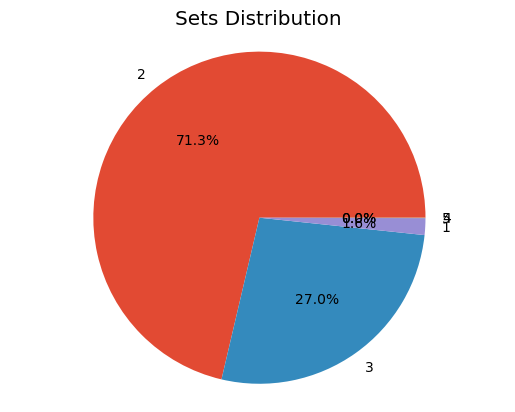

In [74]:
sets_counts = new_df['Sets'].value_counts()

plt.pie(sets_counts, labels=sets_counts.index, autopct='%1.1f%%')
plt.title('Sets Distribution')
plt.axis('equal')
plt.savefig('piechart_sets.png')
plt.show()

In [ ]:
new_df.loc[(new_df['Sets'] == 4) | (new_df['Sets'] == 5)]

Em cima, é possível ver que temos que alterar algumas linhas em baixo e é isso que vamos fazer.

In [ ]:
new_df.loc[(new_df['PlayerName'] == "Tsung-Hua Yang") & (new_df['Sets'] == 4), 'Sets'] = 3
new_df.loc[(new_df['PlayerName'] == "Michael Llodra") & (new_df['Sets'] == 4),'Sets']=3
new_df.loc[(new_df['PlayerName'] == "Fernando Gonzalez") & (new_df['Sets'] == 4),'Sets'] = 3

In [ ]:
new_df['Sets'].value_counts()

Em baixo, vamos eliminar os jogos que tem mais que 3 sets.

In [ ]:
new_df = new_df.drop(new_df[new_df['Sets'] > 3].index)

### Diferenças de idade entre os jogadores

Em baixo, vamos calcular a idade dos jogadores (PlayerName e Oponent) e depois também calcular a diferença de idade entre eles.

In [ ]:
new_df[['Start_Date', 'End_Date']] = new_df['Date'].str.split(' - ', expand=True) #Criação de 2 novas colunas

In [ ]:
#Em baixo, vamos transformar as nossas 3 colunas e formatá-las.
new_df['Start_Date'] = pd.to_datetime(new_df['Start_Date'], format='%Y.%m.%d')
new_df['End_Date'] = pd.to_datetime(new_df['End_Date'], format='%Y.%m.%d')
new_df['BornDate'] = pd.to_datetime(new_df['BornDate'], format='%Y.%m.%d')

#Criação da coluna age e transformá-la do tipo '<m8[Y]'. 
new_df['Age_Player'] = (new_df['Start_Date'] - new_df['BornDate']).astype('<m8[Y]')
new_df['OponentBornDate'] = pd.to_datetime(new_df['OponentBornDate'])
new_df['Age_Oponent'] = (new_df['Start_Date'] - new_df['OponentBornDate']).astype('<m8[Y]')

In [ ]:
new_df['Age_Difference'] = abs(new_df['Age_Player'] - new_df['Age_Oponent'])

In [ ]:
new_df.head(6)

In [ ]:
new_df.isna().sum()

In [ ]:
new_df.columns

### Criação de uma nova variável - Seasons

Uma variável que se considerou importante de se criar é a variável "Seasons".

Esta variável consiste em dado uma data de torneio, damos a estação do ano.

Esta será uma variável importante para o modelo, uma vez que o ténis na maioria dos torneios, é jogado em outdoor, e quando jogado em temperaturas mais frias , a bola torna-se mais pesada, resultando em 'rallys' maiores (resultando em mais pontos jogados).

In [ ]:
new_df["Start_Date"] = pd.to_datetime(new_df["Start_Date"])

seasons_mapping = {
    1: "Winter",
    2: "Winter",
    3: "Spring",
    4: "Spring",
    5: "Spring",
    6: "Summer",
    7: "Summer",
    8: "Summer",
    9: "Autumn",
    10: "Autumn",
    11: "Autumn",
    12: "Winter"
}

new_df["Seasons"] = new_df["Start_Date"].dt.month.map(seasons_mapping)

In [ ]:
encoder = LabelEncoder()
new_df["Seasons_Encoded"] = encoder.fit_transform(new_df["Seasons"])

In [ ]:
new_df.head(10)

### Tratamento da variável GameRound

Da variável GameRound, existem alguns valores únicos que podiam ser agrupados.

Como tal, chegamos à conclusão que todas as rondas de qualificação deveriam ser agrupadas como 'Qualifying'.

Que as rondas iniciais do torneio: 'Round of 64', 'Round of 32', 'Round of 16' e 'Quarter-Finals' deveriam ser agrupadas como 'Early Stages'.

E por fim, as seguintes rondas: 'Semi-Finals', 'Finals' e 'Olympic Bronze' deveriam ser agrupadas como 'Final Stages'.

Decidiu-se deixar o Round Robin numa única categoria, uma vez que esta é uma ronda típica dos ATP Finals (torneios jogados tipicamente no final do ano, onde todos jogam contra todos, uma espécie de fase de grupos).

In [ ]:
table = new_df.groupby(["GameRound", "Sets"]).size().unstack()

# Rename the columns for clarity
table = table.rename(columns={2: "Sets_2", 3: "Sets_3"})
table = table.fillna(0)

print(table)

In [ ]:
new_df["GameRound"].value_counts()

In [ ]:
group_mapping = {
    "Olympic Bronze": "Final Stages",
    "Semi-Finals": "Final Stages",
    "Finals": "Final Stages",
    "1st Round Qualifying": "Qualifying",
    "2nd Round Qualifying": "Qualifying",
    "3rd Round Qualifying": "Qualifying",
    "Round of 32": "Early Stages",
    "Round of 64": "Early Stages",
    "Quarter-Finals": "Early Stages",
    "Round of 16": "Early Stages"
}

new_df["GameRound_Fases"] = new_df["GameRound"].replace(group_mapping)

In [ ]:
new_df["GameRound_Fases"].value_counts()

In [ ]:
value_counts = new_df["GameRound_Fases"].value_counts()

value_counts.plot(kind='bar')

plt.title("Value Counts of GameRound_Fases")
plt.xlabel("GameRound_Fases")
plt.ylabel("Count")
plt.show()

In [ ]:
table = new_df.groupby(["GameRound_Fases", "Sets"]).size().unstack()
table["Sets_2_Percentage"] = (table[2] / table.sum(axis=1)) * 100
table["Sets_3_Percentage"] = (table[3] / table.sum(axis=1)) * 100
table = table.rename(columns={2: "Sets_2", 3: "Sets_3"})
table = table.fillna(0)
print(table)

In [ ]:
encoder = LabelEncoder()
new_df["GameRoundFases_Encoded"] = encoder.fit_transform(new_df["GameRound_Fases"])

In [ ]:
new_df.head(6)

In [ ]:
new_df.columns

### Intervalar algumas variáveis

De seguida, vamos intervalar as seguintes variáveis:

- Age_Difference;

- Ranking_Diff.

O Age_Difference será intervalado por valores que achamos que façam diferença para os sets. Na nossa ótica:

- Uma diferença de 0 a 5 anos, não tem impacto nenhum no decorrer do jogo;

- Uma diferença de 5 a 10 anos, poderá resultar em também jogos mais longos, uma vez que o jogador mais velho deverá ter indices fisicos parecidos ao mais novo;

- Uma diferença de 10 a 15 anos poderá resultar tanto em jogos mais curtos como mais longos;

- Uma diferença de 15 a 20 anos, deverá resultar em jogos mais curtos, onde aí o jogador mais novo deverá ter melhores índices físicos;

- Uma diferença superior a 20 anos, deverá resultar em jogos extremamente curtos.

Em relação ao Ranking difference, esta deverá ser uma variável em forma de intervalo, uma vez, que alguns dos rankings foram substituídos por 9999 e de forma, a não dar um grande peso a essas imputações decidimos intervalar essas variáveis.

No ranking, consideramos os seguintes intervalos:

- [0,50] - Uma diferença pequena de ranking não deverá ter um grande impacto na duração do jogo. Ou seja, a diferença é demasiado pequena para podermos dizer que o jogo vai ser de pequena duração; sendo que à partida pequenas diferenças de ranking entre os jogadores, deverão resultar em jogos renhidos;

- [50,100] - Uma diferença moderada de ranking, também deverá resultar em jogos renhidos, apesar de não tão renhidos como o intervalo em cima;

- [100,200] - Esta é uma diferença mais elevada de ranking. O jogador com menor ranking deverá ter maior superioridade , mas não é suficiente para automaticamente dizermos que o jogo vai ser de curta duração.

- [200,500] - Aqui, esta diferença de ranking é possível dizer que o jogador com menos ranking já deverá ter mais 'skill', poderá ser possível dizer que os jogos serão de curta duração;

- A partir de 500, aqui esta diferença de ranking é estrondosa, podendo dizer que os jogos serão de curta duração.

In [ ]:
intervals = [0, 6, 11, 16, 21, float('inf')]
labels = ['[0,5]', '[6,10]', '[11,15]', '[16,20]', '>20']
new_df['Age_Difference_Interval'] = pd.cut(new_df['Age_Difference'], bins=intervals, labels=labels, right=False)

In [ ]:
label_encoder = LabelEncoder()
new_df['Encoded_Age_Difference_Interval'] = label_encoder.fit_transform(new_df['Age_Difference_Interval'])

In [ ]:
new_df.head(6)

In [ ]:
intervals = [0, 51, 101, 201, 501, float('inf')]
labels = ['[0,50]', '[51,100]', '[101,200]', '[201,500]', '>500']
new_df['Ranking_Difference_Interval'] = pd.cut(new_df['Ranking_Diff'], bins=intervals, labels=labels, right=False)

In [ ]:
label_encoder = LabelEncoder()
new_df['Encoded_Ranking_Difference_Interval'] = label_encoder.fit_transform(new_df['Ranking_Difference_Interval'])

In [ ]:
new_df.head(6)

### Born e Alturas

Ainda temos alguns NA's na variável Height. Como consideramos que esta variável é fulcral na decisão de um jogo, vamos imputar esses NA's.

Para os imputar, escolhemos imputar pela média da altura dos jogadores do continente de onde nasceram. 

In [ ]:
new_df['Born'] = new_df['Born'].str.split(',').str[1]
new_df['Born'] = new_df['Born'].str[1:]

In [ ]:
df_born_location = pd.read_csv('born_location.csv', sep=',')

In [ ]:
for index, row in new_df.iterrows():
    name = row['PlayerName']
    matching_row = df_born_location[df_born_location['PlayerName'] == name]
    if not matching_row.empty:
        born = matching_row['Born'].iloc[0]
        new_df.loc[index, 'Born'] = born

In [ ]:
Africa = ['South Africa',
          'Tunisia',
          'Morocco',
          'Nigeria',
          'Egypt',
          'RSA',
          'S.A.',
          'Madagascar',
          'Mauritius',
          'Zimbabwe']

afr = new_df['Born'].isin(Africa)

new_df.loc[afr, 'BornContinent'] = 'Africa'

In [ ]:
Asia = ['South Korea',
        'Chinese Taipei',
        'Japan',
        'Israel',
        'India',
        'Uzbekistan',
        'Vietnam',
        'Hyogo',
        'Thailand',
        'Korea',
        'Pakistan',
        'Indonesia',
        'Philippines',
        'Kazakhstan',
        'Kuwait',
        'Armenia']

asi = new_df['Born'].isin(Asia)

new_df.loc[asi, 'BornContinent'] = 'Asia'

In [ ]:
China = ['China',
         'Taiwan',
         'Taipei',
         'hina']

chi = new_df['Born'].isin(China)

new_df.loc[chi, 'BornContinent'] = 'China'

In [ ]:
Europe = ['Serbia',
          'Mallorca',
          'Italy',
          'Poland',
          'Switzerland',
          'Hungary',
          'Finland',
          'France',
          'Slovakia',
          'Spain',
          'England',
          'Montenegro',
          'Germany',
          'Ukraine',
          'Portugal',
          'Belgium',
          'Monaco',
          'Austria',
          'Latvia',
          'Great Britain',
          'Lithuania',
          'Bulgaria',
          'Estonia',
          'Guip zcoa',
          'Belarus',
          'Ireland',
          'Slovenia',
          'Bosnia-Herzegovina',
          'Czech Repbulic',
          'Moldova',
          'Netherlands',
          'Croatia',
          'Norway',
          'Sweden',
          'Czech Republic',
          'Greece',
          'Czechoslovakia',
          'Scotland',
          'Macedonia',
          'Romania',
          'Czech Republic ',
          'The Netherlands',
          'Luxembourg',
          'Denmark',
          'Slovak Republic',
          'Andorra',
          'Barcelona',
          'Bosnia and Herzegovina',
          'Vaud',
          'Veneto',
          'Essex',
          'Bosnia & Herzegovina',
          'kraine',
          ' Serbia',
          'Russia',
          'Turkey']

eur = new_df['Born'].isin(Europe)

new_df.loc[eur, 'BornContinent'] = 'Europe'

In [ ]:
North_America = ['Canada',
                 'CA',
                 'IL',
                 'FL',
                 'A',
                 'USA',
                 'TN',
                 'Guadeloupe',
                 'New York',
                 'Maryland',
                 'Ontario',
                 'MO',
                 'NC',
                 'MI',
                 'Georgia',
                 'MD',
                 'NY',
                 'NE',
                 'GA',
                 'TX',
                 'Dominican Republic',
                 'LA',
                 'NV',
                 'Mexico',
                 'Ohio',
                 'Minnesota',
                 'Mississippi',
                 'California',
                 'OK',
                 'Barbados',
                 'Nebraska',
                 'Michigan',
                 'WA',
                 'Illinois',
                 'El Salvador',
                 'D.C.',
                 'New Jersey',
                 'Quebec',
                 'West Virginia',
                 'NJ',
                 'MA',
                 'Bahamas',
                 'MN',
                 'Florida',
                 'AZ',
                 'BC',
                 'HI',
                 'OH']

na = new_df['Born'].isin(North_America)

new_df.loc[na, 'BornContinent'] = 'North America'

In [ ]:
Oceania = ['Australia',
           'New Zealand',
           'South Australia',
           'Solomon Islands',
           'NSW',
           'New Zealand ',
           'Victoria',
           'QLD',
           'QSLD']

oce = new_df['Born'].isin(Oceania)

new_df.loc[oce, 'BornContinent'] = 'Oceania'

In [ ]:
South_America = ['Argentina',
                 'Brazil',
                 'Chile',
                 'Colombia',
                 'Peru',
                 'Paraguay',
                 'Ecuador',
                 'Venezuela',
                 'Uruguay']

sa = new_df['Born'].isin(South_America)

new_df.loc[sa, 'BornContinent'] = 'South America'

In [ ]:
new_df['BornContinent'] = new_df['BornContinent'].fillna('Europe')

In [ ]:
new_df['BornContinent'].unique()

In [ ]:
new_df.head(6)

In [ ]:
new_df.isna().sum()

In [ ]:
new_df.loc[new_df['Height'].isna(), 'PlayerName'].unique()

### Imputação do 'Height' e 'Oponent_Height'

Como se pode ver em baixo, não se pode usar o KNN.

In [ ]:
from sklearn.impute import KNNImputer

df_imputed = new_df.copy()
height_values = df_imputed["Height"].values.reshape(-1, 1)
knn_imputer = KNNImputer(n_neighbors=6)
imputed_height_values = knn_imputer.fit_transform(height_values)
df_imputed["Imputed_Height"] = imputed_height_values
df_imputed["Imputed_Height"].isnull().sum()

In [ ]:
df_imputed.head(6)

In [ ]:
df_imputed.loc[df_imputed["PlayerName"] == "Kento Takeuchi", "Imputed_Height"]

In [ ]:
new_df.head(6)

In [ ]:
mean_height_by_continent = new_df.groupby("BornContinent")["Height"].transform("mean")
new_df["Height_Imputed"] = new_df["Height"].fillna(mean_height_by_continent)

In [ ]:
merged_df = pd.merge(new_df, new_df, left_on='PlayerName', right_on='Oponent', how='left')
new_df['Oponent_Height'] = merged_df['Height_Imputed_y'].where(merged_df['Height_Imputed_y'].notnull(), pd.NA)

In [ ]:
new_df.isna().sum()

In [ ]:
new_df.head(6)

### Diferenças de Altura

In [ ]:
new_df['Height_Difference'] = (new_df['Height_Imputed'] - new_df['Oponent_Height']).abs()

In [ ]:
intervals = [0, 6, 11, 16, 21, float('inf')]

# Define the corresponding labels for the intervals
labels = ['[0,5]', '[6,10]', '[11,15]', '[16,20]', '>20']

# Create a new column 'age_difference_interval' based on the intervals
new_df['Height_Difference_Interval'] = pd.cut(new_df['Height_Difference'], bins=intervals, labels=labels, right=False)

In [ ]:
new_df.head(6)

In [ ]:
label_encoder = LabelEncoder()
new_df['Encoded_Height_Difference_Interval'] = label_encoder.fit_transform(new_df['Height_Difference_Interval'])

### Prize

Na variável Prize, todos os prizes já estão em dólares americanos, portanto, não vai ser necessário transferir a moeda.

O importante nesta variável é atualizar a taxa de inflação para as datas atuais e é isso que em baixo, vamos realizar.

Portanto, o tratamento da variável passa pela retirada das vírgulas, do "$" e a transformarmos em variável numérica.

Depois, passa pela atualização das taxas.

In [ ]:
new_df.isna().sum()

In [ ]:
new_df['Prize'] = new_df['Prize'].str.replace(',', '')
new_df['Prize'] = new_df['Prize'].str.replace('$', '')

In [ ]:
new_df['Prize'] = new_df['Prize'].fillna(0)

In [ ]:
new_df['Prize'] = new_df['Prize'].astype(int)

In [ ]:
currency = pd.read_csv('inflation.csv', sep=';')

In [ ]:
new_df['Tournament_Year'] = new_df['Start_Date'].dt.year.astype(str)

In [ ]:
currency['CONVERSION'] = pd.to_numeric(currency['CONVERSION'])

In [ ]:
new_df['Tournament_Year'] = new_df['Tournament_Year'].astype(int)

In [ ]:
for index, row in new_df.iterrows():
    link = row['Tournament_Year']
    matching_rows = currency[currency['YEAR'] == link]
    if not matching_rows.empty:
        birthdate = matching_rows.iloc[0]['CONVERSION']
        new_df.loc[index, 'Conversion'] = birthdate

In [ ]:
new_df['Present_Prize'] = new_df['Prize'] * new_df['Conversion']

In [ ]:
new_df.head(6)

In [ ]:
new_df['Present_Prize'].unique()

### Tiebreak

Nesta variável, vamos a cada jogo verificar se existe tiebreak, à partida, se existirem TieBreaks os jogos deverão ser mais renhidos.

In [ ]:
list1 = ['62-63', '64-62', '60-62', '63-63', '63-64', '61-63', '62-64','62-61', '42', '61-76', '64-36-64', '62-62', '76-76', '16-64-61','60-60', '63-62', '63-76', '62-63-62', '62-76', '63-75', '61-62','16-64-75', '62-60', '64-64', '76-46-76', '46-75-61', '60-63','76-46-60', '36-64-63', '61-61', '60-41', '76-61', '60-61','67-64-63', '64-63', '64-76', '76-63', '62-36-63', '67-75-61','63-61', '52', '46-76-62', '76-36-76', '67-62-63', '60-75','63-46-62', '32', '26-75-76', '46-62-61', '61-64', '64', '61-60','76-16-62', '60-76', '75-63', '61-75', '60-64', '16-63-61','63-26-62', '76-26-63', '62-16-63', '36-62-63', '76-62', '62-75','64-36-63', '76-75', '64-36-76', '16-75-63', '26-63-63','36-64-75', '54', '43', '50', '46-64-64', '36-61-62', '16-75-64','75-62', '63-60', '75-67-62', '75-20', '64-46-61', '46-75-75','76-60', '64-75', '61-46-63', '63-42', '64-30', '62-67-64','36-64-61', '61-36-60', '64-61', '67-61-60', '61-41', '62-36-62','10', '75-75', '62-46-76', '16-61-63', '75-64', '76-57-61','62-26-63', '36-63-62', '76-36-62', '36-63-64', '67-62-62','46-76-64', '46-62-62', '63-46-61', '76-64', '75-61', '60-67-75','63-20', '62-36-64', '57-64-62', '62-46-63', '76', '76-46-64','62-40', '57-64-61', '60', '46-60-63', '63-16-62', '67-64-64','64-60', '64-57-64', '36-75-64', '67-61-76', '36-62-61','63-57-64', '76-46-61', '64-10', '26-63-62', '46-75-63','36-63-75', '67-60-60', '75-76', '36-63-76', '57-64-76','36-61-64', '67-63-76', '64-46-62', '60-46-64', '57-61-53','76-46-63', '46-75-64', '46-63-64', '67-63-63', '61-36-75','60-26-63', '46-61-61', '46-63-62', '62-22', '16-61-62','46-63-61', '62-16-60', '63-10', '61-46-62', '57-64-64','57-63-62', '64-57-61', '16-76-62', '75-21', '46-76-63','61-36-62', '36-76-63', '63-40', '67-64-75', '06-62-75','46-61-62', '63-41', '76-36-63', '63-16-63', '40', '36-61-63','62-20', '46-64-61', '61-30', '36-76-76', '64-46-76', '64-67-62','67-62-64', '63-26-61', '63-67-61', '63-36-61', '64-16-61','46-76-75', '62-26-64', '75-57-64', '63-57-63', '61-16-75','46-63-75', '26-63-64', '67-60-62', '67-63-64', '06-64-62','61-67-63', '46-61-63', '16-63-63', '76-67-62', '63-36-63','16-61-75', '46-61-64', '67-63-62', '67-42', '57-60-63','63-67-62', '62-57-64', '76-57-63', '67-62-76', '36-75-75','63-46-64', '61-36-76', '75-26-62', '57-76-63', '61-67-62','63-16-61', '76-06-75', '36-76-64', '67-76-64', '64-67-63','75-67-76', '26-64-61', '36-63', '75-67-63', '63-76-63','64-16-64', '57-61-62', '63-67-63', '46-76-76', '36-75-63','75-36-76', '57-76-64', '64-67-61', '61-46-61', '76-40','76-57-64', '67-76-62', '57-64-63', '46-60-30', '67-76-63','61-67-64', '67-75-64', '46-64-76', '61-31', '76-46-75', '76-10','16-63-64', '76-67-64', '75-26-63', '60-40', '63-30', '76-36-64','63-26-64', '67-64-76', '67-75-62', '26-61-64', '67-64-20','67-64-62', '61-67-75', '75-60', '57-75-64', '62-41', '36-64-62','62-46-60', '57-63-63', '76-16-63', '36-75-76', '76-67-76','46-63-76', '63-46-63', '62-67-63', '62-26-60', '57-63-64','64-26-61', '46-64-62', '36-63-61', '64-46-64', '36-63-63','46-76-60', '60-63-64', '36-61-61', '60-16-62', '63-26-76','60-46-62', '63-46-76', '62-36-60', '36-64-64', '30', '46-62-64','62-46-64', '16-76-60', '67-61-64', '76-46-62', '61-36-63','75-67-64', '46-64-63', '57-76-76', '76-26-76', '67-60-63','26-64-62', '26-62-75', '61-26-62', '62-26-62', '76-21','75-46-63', '62-46-75', '75-16-61', '76-16-76', '64-57-63','46-64-75', '57-61-64', '64-46-75', '76-20', '67-63-60','67-76-76', '46-63-63', '64-26-64', '26-64-64', '62', '46-75-62','16-63-76', '61-10', '63-57-61', '67-75-63', '26-76-75','36-60-63', '16-64-64', '64-36-61', '06-75-76', '64-16-63','46-76-61', '26-63-61', '57-60-50', '60-67-61', '75-36-63','67-75-76', '63', '36-65', '36-76-61', '67-61-63', '64-36-60','36-62-76', '67-62-30', '67-63-40', '62-36-76', '57-62-63','63-67-64', '26-62-61', '62-30', '46-61-60', '60-10', '63-36-75','57-63-76', '62-67-76', '63-67-76', '36-64-76', '06-76-75','36-75-62', '16-62-61', '26-64-76', '64-67-64', '76-67-63','16-76-64', '75', '64-57-76', '64-36-62', '16-64-63', '36-76-62','57-63-61', '36-61-75', '63-26-63', '76-36-75', '75-26-64','64-67-76', '46-62-63', '64-06-61', '67-64-61', '64-26-75','61-12', '76-16-64', '62-67-62', '60-30', '36-62-62', '41','46-61-76', '76-41', '63-67-75', '16-62-76', '62-36-61','61-46-64', '75-57-75', '76-57-62', '57-76-61', '76-36-43','60-36-63', '57-63-75', '46-63-60', '67-61-61', '63-01','36-62-75', '57-60-64', '26-76-76', '26-61-62', '67-61-62','61-67-61', '62-67-75', '61-36-61', '75-16-76', '67-76-75','46-75-60', '62-67-61', '75-26-76', '61-20', '64-46-86','63-46-60', '36-60-61', '63-36-62', '36-76-60', '26-75-63','46-75-20', '06-64-76', '62-54', '75-46-62', '61-67-76','63-36-64', '26-64-63', '62-21', '64-06-63', '64-40', '63-16-76','60-20', '75-36-61', '26-62-64', '20', '36-60-76', '26-62-62','75-46-75', '57-61-63', '63-36-60', '63-06-64', '26-76-51','75-67-75', '76-67-61', '22', '61-57-62', '64-57-75', '63-57-75','76-67-60', '36-61-76', '67-62-75', '64-06-75', '16-75-61', '61','67-76-61', '34', '06-63-61', '61-01', '63-46-75', '16-76-75','57-62-62', '36-60-64', '62-57-63', '64-26-62', '75-46-61','60-31', '06-75-63', '61-26-64', '63-21', '64-55', '61-42','26-61-75', '64-26-63', '57-76-75', '57-62-61', '62-57-62','75-46-64', '46-64-60', '62-43', '26-76-63', '26-76-64','75-36-64', '57-76-60', '62-26-61', '26-62-76', '53', '63-36-76','57-61-30', '64-46-63', '46-62-76', '64-67-75', '16-76-63','46-75-76', '62-67-60', '36-21', '62-16-62', '61-16-62','57-62-75', '75-67-61', '06-63-75', '76-26-75', '76-26-62','60-16-63', '26-75-50', '46-75', '31', '76-57-75', '64-06-64','57-76-62', '63-06-76', '75-10', '06-64-64', '16-62-64','62-36-75', '76-26-64', '75-16-75', '57-62-64', '16-76-61','62-46-62', '26-60-62', '62-26-76', '16-76-76', '75-36-62','62-57-75', '61-21', '06-64-75', '63-57-62', '64-16-75','61-16-64', '61-57-76', '26-63-60', '46-60-75', '63-57-60','61-57-64', '26-55', '36-61-60', '62-67-40', '16-75-62','61-16-76', '63-43', '60-26-76', '36-61-10', '46-61-75','16-60-75', '16-62-63', '36-64-60', '46-76-10', '61-57-60','76-26-61', '75-06-76', '63-67-60', '64-26-42', '26-75-64','61-46-76', '64-36-75', '26-63-40', '64-24', '57-62-42','16-64-62', '36-32', '33', '57-62-76', '67-63-75', '67-52','46-21', '57-64-20', '60-11', '46-33', '67-63-41', '26-76-32','64-26-76', '01', '62-66', '26-75-61', '46-32', '06-76-60','64-57-62', '36-62-64', '65', '64-31', '60-67-64', '76-16-61','46-75-32', '26-63-41', '36-76-65', '61-36-64', '76-30','67-62-60', '76-36-61', '67-61-75', '46-64-50', '24', '46-60-64','60-67-60', '63-06-63', '46-60-61', '23', '26-75-75', '36-60-40','46-63-20', '67-63-61', '64-46-60', '06-76-63', '36-63-54','63-57-76', '62-10', '46-75-10-', '46-64-10', '36-63-60', '64-21','62-36-23', '76-54', '57-64-75', '67-61', '26-61-76', '57-60-61','06-62-64', '26-63-75', '76-06-64', '61-26-76', '26-63-76','36-76-31', '62-32', '63-50', '57-63-60', '26-61-63', '57-76-42','12', '26-52', '75-16-62', '64-36-21', '16-61-76', '26-60-63','76-67-75', '26-76-10', '16-63-75', '57-61-60', '26-62-63', '11','62-16-76', '67-64-21', '67-33', '62-67-30', '57-34', '46-61-10','16-61-61', '61-06-62', '63-26-75', '57-75-76', '06-64-63','36-62-20', '46-62-60', '16-63-62', '16-75-76', '62-31', '46-51','76-32', '36-76-30', '36-60-62', '75-06-75', '76-06-63','61-06-64', '62-26-75', '46', '62-16-64', '46-76', '75-57-76','36-66', '67-75', '51', '60-01', '75-66', '67-64-60', '60-67-63','67-75-60', '46-63-30', '76-31', '67-64-43', '67-62-61','61-16-61', '46-63-46', '75-46-76', '26-75-10', '16-62-75','26-40', '21', '26-60-64', '57-60-60', '62-53', '06-40','75-16-63', '61-40', '26-41', '57-20', '26-76-61', '06-76-76','03', '26-75-40', '67-62-20', '76-42', '67-41', '26-76-62','75-57-62', '63-46-31', '63-31', '62-57-61', '26-62-60','60-26-64', '57-60-62', '36-53', '75-57-61', '57-62-20','61-46-75', '26-64-75', '57-61-61', '61-50', '36-61-20','57-75-75', '57-75-61', '63-52', '60-36-61', '26-75-62','67-61-86', '16-64-60', '16-62-20', '16-63', '64-16-76','46-76-55', '62-16-61', '63-16-64', '06-62-60', '36-76-75','75-36-75', '64-20', '64-26-12', '67-61-30', '46-61-21','63-46-10', '36-76-42', '46-60-76', '67-76-60', '62-57-60','36-76-20', '36-62-32', '26-75-31', '46-60-62', '75-06-64','64-53', '62-67-53', '57-76-30', '36-64-52', '64-51', '44','46-64', '16-61-64', '64-42', '63-16-75', '26-76-30', '36-64-41','62-16-75', '75-30', '26-63', '46-76-30', '46-61-41', '75-67-30','64-36-41', '55', '46-76-31', '36-76', '16-60-76', '46-61','76-57-76', '62-06-64', '46-64-30', '75-36-60', '36-75-20','60-42', '64-43', '67-64-31', '67-65', '57-64', '46-75-10','06-76-61', '06-63-76', '57-75', '62-57-76', '26-64-60', '63-51','62-46-61', '06-62-76', '60-36-75', '06-62-63', '61-16-60', '25','46-76-11-', '61-06-61', '61-57-30', '64-01', '36-75-21','61-06-63', '76-23', '64-41', '57-60-75', '57-75-32', '36-75-60','26-76-11', '64-36-01', '64-16-62', '57-75-63', '46-23','76-26-40', '46-62-75', '16-62-62', '60-16-64', '16-75-75','46-22', '67-60-76', '61-26-60', '46-75-41', '67-60-64','16-64-76', '76-06-76', '46-', '61-57-61', '57-75-62', '36-75-61','75-67-22', '46-75-11-', '36-63-40', '64-26-46', '46-75-55','26-76-60', '16-63-60', '63-16-60', '36-42', '62-', '26-61-51','62-42', '26-60-61', '61-51', '63-46-33', '06-61-64', '76-67-40','60-67-42', '76-36-21', '64-50', '76-16-75', '67-10', '16-64-40','26-61-61', '76-06-62', '61-11', '63-46-41', '46-62-41','64-67-60', '57-61-76', '61-57-63', '36-52', '36-62-60','61-16-63', '64-06-62', '76-33', '64-06-76', '76-64-63', '63-22','60-46-61', '36-75', '64-16-60', '62-57-53', '63-67-42', '76-11','61-26-63', '75-57-63', '66', '57-62-30', '36-63-10', '06-63-63','26-34', '57-53', '46-76-40', '26-60-75']

In [ ]:
list1 = [item for item in list1 if '7' not in item]
list1 = [item for item in list1 if '8' not in item]

print(list1)

In [ ]:
new_df['Tiebreak'] = 1

In [ ]:
new_df.loc[new_df['Score_Sets'].isin(list1), 'Tiebreak'] = 0

In [ ]:
relative_frequency = new_df['Tiebreak'].value_counts(normalize=True)
print(relative_frequency)

### Eliminação de jogos

Em baixo, vamos eliminar os jogos que acabaram ainda no decorrer do primeiro set.

Estes correspondem a 1.62% da base de dados (existem 210 jogos). 

Um jogo só acaba no primeiro set caso um jogador se retire, como queremos que o nosso modelo pelo menos preveja quantos sets demora um jogo acabar, caso deixássemos os jogos com 1 set, o que estaria a acontecer é que estaríamos a prever quando é que um jogo pode acabar mais cedo do que é suposto.

In [ ]:
new_df.shape

In [ ]:
(new_df["Sets"] == 1).sum()

In [ ]:
new_df=new_df[new_df["Sets"] != 1]

In [ ]:
new_df.to_csv('new_df.csv', index=False)

### Filtragem das Colunas

In [ ]:
new_df.columns

In [ ]:
df_final = new_df[["Ranking_Diff", "Sets", "Age_Difference","Seasons_Encoded","GameRoundFases_Encoded","Encoded_Age_Difference_Interval","Encoded_Ranking_Difference_Interval","Encoded_Height_Difference_Interval","Present_Prize","Tiebreak","Tournament_Encoded"]]

In [ ]:
df_final.head(6)

In [ ]:
df_final.shape

### PieCharts

In [ ]:
agi_counts = new_df['Age_Difference_Interval'].value_counts()

plt.pie(agi_counts, labels=agi_counts.index, autopct='%1.1f%%')
plt.title('Encoded_Age_Difference_Interval Distribution')
plt.axis('equal')
plt.savefig('piechart_age_diff_int.png')
plt.show()

In [ ]:
tt_counts = new_df['TournamentType'].value_counts()

plt.pie(tt_counts, labels=tt_counts.index, autopct='%1.1f%%')
plt.title('Tournament_Encoded Distribution')
plt.axis('equal')
plt.savefig('piechart_tournament_encoded.png')
plt.show()

In [ ]:
gr_counts = new_df['GameRound_Fases'].value_counts()

plt.pie(gr_counts, labels=gr_counts.index, autopct='%1.1f%%')
plt.title('GameRound_Encoded Distribution')
plt.axis('equal')
plt.savefig('piechart_game_round.png')
plt.show()

In [ ]:
rd_counts = new_df['Ranking_Difference_Interval'].value_counts()

plt.pie(rd_counts, labels=rd_counts.index, autopct='%1.1f%%')
plt.title('Encoded_Ranking_Difference_Interval Distribution')
plt.axis('equal')
plt.savefig('piechart_rank_diff.png')
plt.show()

In [ ]:
s_counts = new_df['Seasons'].value_counts()

plt.pie(s_counts, labels=s_counts.index, autopct='%1.1f%%')
plt.title('Seasons_Encoded Distribution')
plt.axis('equal')
plt.savefig('piechart_seasons.png')
plt.show()

### Export do ficheiro

In [ ]:
df_final.to_csv('df_final.csv', index=False)